# Traing Models target 1: Livello_Acqua

## Libreries set up

In [1]:
import matplotlib as mpl
%matplotlib inline
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from xgboost import XGBRegressor , plot_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit , GridSearchCV, RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFECV
import warnings
warnings.filterwarnings('ignore')

In [2]:
seed = np.random.seed(22)
rng = np.random.RandomState(1)

In [3]:
os.chdir("../")
print(os.getcwd())

c:\Users\nabil\Downloads\Progetto_industry


## XGBoost Model Traing and Selection

Il modello migliore risultante tra quelli testati e provati è l'XGBoost, si riportano tutti gli step seguiti per arrivare al mioglior set di parametri e variabili

Carico i dati preparati nel notebook di preparation

In [4]:
xgb_train_data = pd.read_csv('Data/Prepared/train_SL.csv')
xgb_train_data['Data'] = pd.to_datetime(xgb_train_data['Data'], format="%Y-%m-%d")
xgb_train_data.set_index('Data', inplace=True)
X = xgb_train_data.drop(['Target'],axis=1)
y = xgb_train_data['Target']

### 2.1) GridSerachCV

Si effettua una ricerca degli iperparametri, poichè stiamo utilizzando delle serie temporali è necessario usre una tipolagia di crossvalidation adeguata, a tal proposito viene utilizzata TimeSeriesSplit con 10 split.

In [5]:
tscv = TimeSeriesSplit(n_splits=10)
gsc = GridSearchCV(
            estimator=XGBRegressor(),
            param_grid={'objective' :['reg:squarederror'],
                        "learning_rate": (0.5,0.001 ,0.05, 0.15),
                        'n_estimators': [150,200],
                        'subsample': [0.7,0.9],
                        "max_depth": [ 2,3, 4],
                        "min_child_weight": [ 5, 7,10],
                        "gamma":[ 0.01, 0.1, 0.2],
                        "colsample_bytree":[ 0.3, 0.4],
                         "booster" : ['gbtree','gblinear'],
                        'random_state':[123],
                        'seed': [456]},
            cv=tscv, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1,)



In [6]:
gsc.fit(X,y)

Fitting 10 folds for each of 1728 candidates, totalling 17280 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=XGBRegressor(), n_jobs=-1,
             param_grid={'booster': ['gbtree', 'gblinear'],
                         'colsample_bytree': [0.3, 0.4],
                         'gamma': [0.01, 0.1, 0.2],
                         'learning_rate': (0.5, 0.001, 0.05, 0.15),
                         'max_depth': [2, 3, 4], 'min_child_weight': [5, 7, 10],
                         'n_estimators': [150, 200],
                         'objective': ['reg:squarederror'],
                         'random_state': [123], 'seed': [456],
                         'subsample': [0.7, 0.9]},
             scoring='neg_mean_squared_error', verbose=1)

Risultato con tutti i Migliori Parametri

In [7]:
gsc.best_params_

{'booster': 'gbtree',
 'colsample_bytree': 0.4,
 'gamma': 0.2,
 'learning_rate': 0.05,
 'max_depth': 3,
 'min_child_weight': 10,
 'n_estimators': 200,
 'objective': 'reg:squarederror',
 'random_state': 123,
 'seed': 456,
 'subsample': 0.7}

### 2.2) Feature Selection&Importance

In [8]:
params=gsc.best_params_

Si Addestrta il modello e si visulizza l'importanza delle variabili sul train

<BarContainer object of 24 artists>

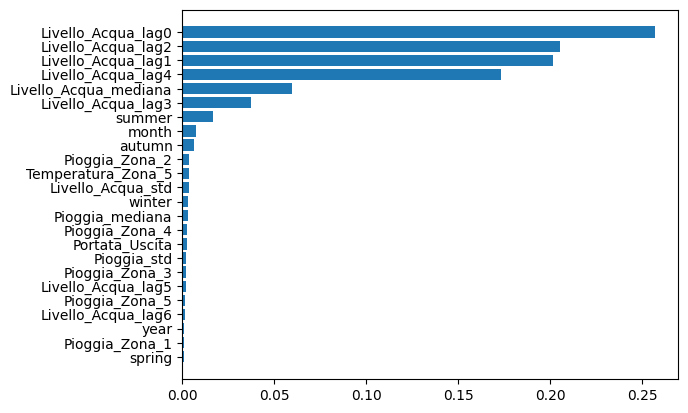

In [9]:
model = XGBRegressor(**params)
model_fit = model.fit(X, y)
sorted_idx = model_fit.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], model_fit.feature_importances_[sorted_idx])

Si utilizza una Recursive Feature Selection con CV per selezionare le feature migliori

In [10]:
estimator = XGBRegressor(**params)

In [11]:
selector = RFECV(estimator, cv=tscv, scoring='neg_mean_squared_error')
selector = selector.fit(X, y)

Si noti che vengono selezionate 16 variabili su 24 totali, sebbene ci sia poca differenza nello score.

In [12]:
selector.ranking_

array([8, 1, 1, 1, 4, 1, 1, 3, 9, 1, 2, 1, 7, 6, 1, 1, 1, 1, 1, 1, 1, 5,
       1, 1])

In [13]:
selector.n_features_

16

In [14]:
selector.support_

array([False,  True,  True,  True, False,  True,  True, False, False,
        True, False,  True, False, False,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True])

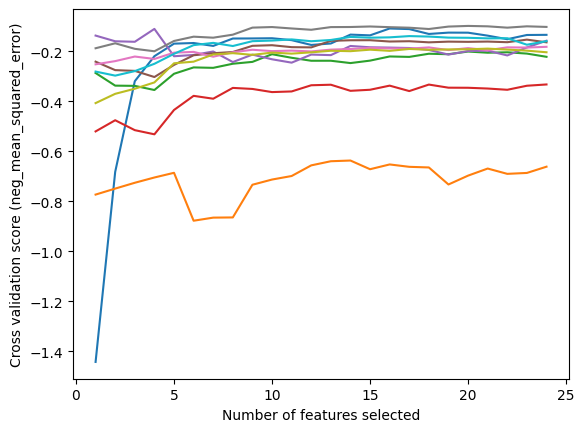

In [15]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (neg_mean_squared_error)")
plt.plot(
    range(1, len(selector.grid_scores_) + 1),
    selector.grid_scores_,
)
plt.show();

### 2.3) Training and Saving

Addestratmento con i dati di Train e salvataggio del modello

In [16]:
model = XGBRegressor(**params)
model_fit = model.fit(X, y)

In [17]:
filename = 'Models/XGB_model_LA.sav'
pickle.dump(model, open(filename, 'wb'))

In [18]:
cols = X.columns[selector.get_support()]

In [19]:
X_new = X[cols]

In [20]:
X_new.shape

(5646, 16)

In [21]:
X_new.columns

Index(['Pioggia_Zona_2', 'Pioggia_Zona_3', 'Pioggia_Zona_4',
       'Temperatura_Zona_5', 'Portata_Uscita', 'summer', 'month',
       'Pioggia_std', 'Livello_Acqua_lag0', 'Livello_Acqua_lag1',
       'Livello_Acqua_lag2', 'Livello_Acqua_lag3', 'Livello_Acqua_lag4',
       'Livello_Acqua_lag5', 'Livello_Acqua_mediana', 'Livello_Acqua_std'],
      dtype='object')

In [22]:
model = XGBRegressor(**params)
model_fit = model.fit(X_new, y)

In [23]:
filename = 'Models/XGB_model_featsel_LA.sav'
pickle.dump(model, open(filename, 'wb'))

# Training Models target 2: Portata_Uscita

## XGBoost Model Traing and Selection

Il modello migliore risultante tra quelli testati e provati è l'XGBoost, si riportano tutti gli step seguiti per arrivare al mioglior set di parametri e variabili

Si caricano i dati preparati del notebook di preparation

In [24]:
train_PU_SL = pd.read_csv('Data/Prepared/train_PU_SL.csv')
train_PU_SL['Data'] = pd.to_datetime(train_PU_SL['Data'], format="%Y-%m-%d")
train_PU_SL.set_index('Data', inplace=True)
X = train_PU_SL.drop(['Target'],axis=1)
y = train_PU_SL['Target']

### 3.1) RandomizeSerachCV

Si effettua una ricerca degli iperparametri, poichè stiamo utilizzando delle serie temporali è necessario usre una tipolagia di crossvalidation adeguata, a tal proposito viene utilizzata TimeSeriesSplit con 3 split.

In [25]:
tscv = TimeSeriesSplit(n_splits=10)
estimator=XGBRegressor()
param_grid={'objective' :['reg:squarederror'],
            "learning_rate": (0.5,0.001 ,0.05, 0.15),
            'n_estimators': [150,200],
            'subsample': [0.7,0.9],
            "max_depth": [ 2,3, 4],
            "min_child_weight": [ 5, 7,10],
            "gamma":[ 0.01, 0.1, 0.2],
            "colsample_bytree":[ 0.3, 0.4],
            "booster" : ['gbtree','gblinear'],
            'random_state':[123],
            'seed': [456]}

In [26]:
rsc = RandomizedSearchCV(estimator,param_grid, cv=tscv,scoring='neg_mean_absolute_error',verbose=1,n_jobs=-1, n_iter=10)

In [27]:
rsc.fit(X,y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
                   estimator=XGBRegressor(), n_jobs=-1,
                   param_distributions={'booster': ['gbtree', 'gblinear'],
                                        'colsample_bytree': [0.3, 0.4],
                                        'gamma': [0.01, 0.1, 0.2],
                                        'learning_rate': (0.5, 0.001, 0.05,
                                                          0.15),
                                        'max_depth': [2, 3, 4],
                                        'min_child_weight': [5, 7, 10],
                                        'n_estimators': [150, 200],
                                        'objective': ['reg:squarederror'],
                                        'random_state': [123], 'seed': [456],
                                        'subsample': [0.7, 0.9]},
                   scoring='neg_mean_absolute_error', verbose=1)

Risultato con tutti i Migliori Parametri

In [28]:
rsc.best_params_

{'subsample': 0.7,
 'seed': 456,
 'random_state': 123,
 'objective': 'reg:squarederror',
 'n_estimators': 150,
 'min_child_weight': 10,
 'max_depth': 3,
 'learning_rate': 0.05,
 'gamma': 0.2,
 'colsample_bytree': 0.4,
 'booster': 'gbtree'}

### 3.2) Feature Selection&Importance

In [29]:
params=rsc.best_params_

Si Addestrta il modello e si visulizza l'importanza delle variabili sul train

<BarContainer object of 65 artists>

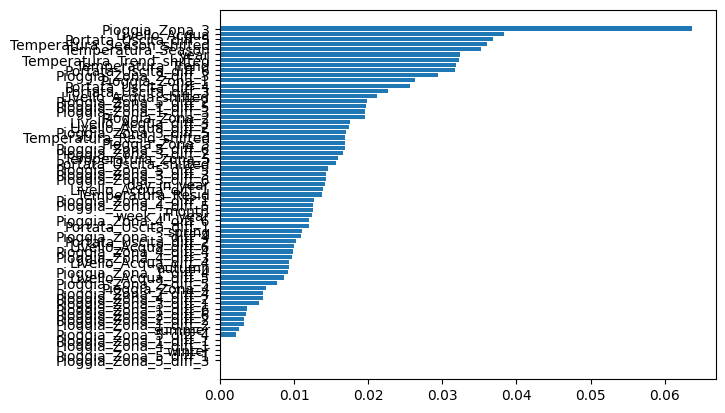

In [30]:
model = XGBRegressor(**params)
model_fit = model.fit(X, y)
sorted_idx = model_fit.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], model_fit.feature_importances_[sorted_idx])

Si utilizza una Recursive Feature Selection con CV per selezionare le feature migliori

In [31]:
estimator = XGBRegressor(**params)

In [32]:
selector = RFECV(estimator, cv=tscv, scoring='neg_mean_squared_error')
selector = selector.fit(X, y)

Si noti che vengono selezionate 59 variabili su 65 totali.

In [33]:
selector.ranking_

array([3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       4, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [34]:
selector.n_features_

59

In [35]:
selector.support_

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

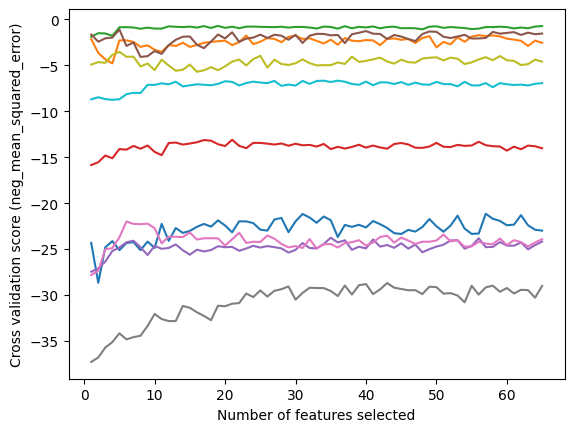

In [36]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (neg_mean_squared_error)")
plt.plot(
    range(1, len(selector.grid_scores_) + 1),
    selector.grid_scores_,
)
plt.show();

In [37]:
min = max(selector.cv_results_['mean_test_score'])
min

-12.868001236461478

In [38]:
arr = np.array(selector.cv_results_['mean_test_score'])
np.where(arr==min)

(array([58], dtype=int64),)

### 3.3) Training and Saving

In [39]:
model = XGBRegressor(**params)
model_fit = model.fit(X, y)

In [40]:
filename = 'Models/XGB_model_PU.sav'
pickle.dump(model, open(filename, 'wb'))

In [41]:
cols = X.columns[selector.get_support()]

In [42]:
X_new = X[cols]

In [43]:
X_new.shape

(4527, 59)

In [44]:
X_new.columns

Index(['Pioggia_Zona_2', 'Pioggia_Zona_3', 'Pioggia_Zona_4', 'Pioggia_Zona_5',
       'Temperatura_Zona_5', 'Livello_Acqua', 'autumn', 'spring', 'summer',
       'year', 'month', 'day_in_year', 'week_in_year', 'Temperatura_Trend',
       'Temperatura_Season', 'Temperatura_Resid', 'Pioggia_Zona_1_diff_1',
       'Pioggia_Zona_2_diff_1', 'Pioggia_Zona_3_diff_1',
       'Pioggia_Zona_4_diff_1', 'Livello_Acqua_diff_1',
       'Portata_Uscita_diff_1', 'Pioggia_Zona_1_diff_2',
       'Pioggia_Zona_2_diff_2', 'Pioggia_Zona_3_diff_2',
       'Pioggia_Zona_5_diff_2', 'Livello_Acqua_diff_2',
       'Portata_Uscita_diff_2', 'Pioggia_Zona_1_diff_3',
       'Pioggia_Zona_2_diff_3', 'Pioggia_Zona_3_diff_3',
       'Pioggia_Zona_4_diff_3', 'Livello_Acqua_diff_3',
       'Portata_Uscita_diff_3', 'Pioggia_Zona_1_diff_4',
       'Pioggia_Zona_2_diff_4', 'Pioggia_Zona_3_diff_4',
       'Pioggia_Zona_5_diff_4', 'Livello_Acqua_diff_4',
       'Portata_Uscita_diff_4', 'Pioggia_Zona_1_diff_5',
       'Pioggi

In [45]:
model = XGBRegressor(**params)
model_fit = model.fit(X_new, y)

In [46]:
filename = 'Models/XGB_model_featsel_PU.sav'
pickle.dump(model, open(filename, 'wb'))